In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [3]:
len(traindataset) // 32


419

In [4]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [5]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-22 12:15:57.782 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [6]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [23]:
# TODO ~ about 4 lines of code

#accuracy = metrics.Accuracy()
#accuracy(y, yhat)



Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [7]:

# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]
    pass


To test the preprocessor:

In [8]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [9]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [10]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 30]),
 tensor([1, 2, 1, 2, 2, 2, 1, 1, 0, 0, 2, 0, 3, 2, 0, 0, 1, 0, 1, 2, 2, 2, 2, 2,
         0, 2, 0, 0, 2, 1, 1, 2]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [28]:
from src.models import metrics
import torch
# TODO ~ 2 lines of code

metrics = metrics.Accuracy()
loss_fn = torch.nn.CrossEntropyLoss()


## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [29]:
log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
from src.models import rnn

config = {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 2,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)

Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [30]:
from src.training import train_model

#model = train_model.trainloop(
    epochs=1,
    model=model,
    metrics=[metrics],
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


IndentationError: unexpected indent (2171242674.py, line 4)

Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

your explanation here

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

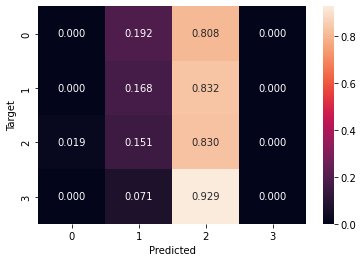

In [31]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

In [ ]:
We choose to implement the model in Traxx and the first assumption we made is that to detect humor at least some knowledge of a setup is needed for a punchline.
We 

In [11]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import trax
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay
from trax.layers.assert_shape import assert_shape
from trax.layers import combinators as cb
from trax.shapes import signature
from trax import layers as tl
from typing import Dict

# implement a learning rate scheduler
lr = warmup_and_rsqrt_decay(100, 0.01)
steps = jnp.arange(1200)
y = [lr(x) for x in steps]
plt.plot(steps, y)



2022-06-22 12:18:59.922082: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


In [14]:
def Cast():
    def f(generator):
        for x, y in generator:
            yield x.numpy(), y.numpy()

    return lambda g: f(g)

In [15]:
data_pipeline = trax.data.Serial(Cast())
trainpipe = data_pipeline(trainstreamer)
testpipe = data_pipeline(teststreamer)

In [16]:
X, y = next(trainpipe)
type(X), type(y)


(numpy.ndarray, numpy.ndarray)

In [17]:
config = {
    "vocab": len(v),
    "hidden_size": 128,
    "features": 50,
    "output_size": 4,
}


In [45]:
def createCustModel(config: Dict):
    model = tl.Serial(
        tl.Embedding(vocab_size=config["vocab"], d_feature=config["hidden_size"]), #MAP to vectors
        tl.GRU(n_units=config["hidden_size"]),  #  use a gated layer to remember words from the beginning of a text to 'understand the story'
        tl.Mean(axis=1), #  take mean values of groups of words, hopefully this generalizing will fix the overfitting we found in the last question
        tl.Dense(config["output_size"]))
    return model
model = createCustModel(config)

In [122]:
#model = tl.Serial(
#    tl.Embedding(vocab_size=8192, d_feature=50),
#    tl.Mean(axis=1),
#    tl.Dense(4),
#    tl.LogSoftmax()
#)

In [46]:

from src.models.traxmodel import summary
model.init_weights_and_state(signature(X))
# let's test a single prediction
ytest = model(X)
ytest

DeviceArray([[ 8.9167571e-04, -2.9031213e-03,  4.4989567e-03,
              -1.5046613e-03],
             [ 4.9375817e-03, -1.9493377e-03,  1.5616132e-03,
               8.0077525e-04],
             [ 5.3910310e-03, -6.3914334e-04, -3.6060996e-05,
               7.2226493e-04],
             [ 8.9313099e-03,  6.0808491e-03, -2.6346734e-03,
               6.4822086e-03],
             [ 2.4499854e-03,  3.5611228e-03, -2.0783858e-03,
              -8.9826045e-04],
             [ 4.1505257e-03,  3.1240055e-04,  3.8402854e-03,
              -1.3981961e-03],
             [ 4.4369786e-03,  4.3334807e-03, -8.8489935e-04,
               1.0776188e-03],
             [ 3.8776458e-03,  1.4576141e-03, -1.9743594e-03,
              -5.0967955e-04],
             [ 1.5659629e-03, -3.2096155e-04,  2.9760741e-03,
              -4.2355489e-03],
             [-1.1567031e-03,  1.9617523e-03,  1.8602348e-03,
              -1.8454865e-03],
             [ 6.0620806e-03,  4.4181626e-03, -2.3123438e-03,
        

In [47]:
from trax.supervised import training
import trax
from trax import layers as tl
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape

log_dir = "../tune"
log_dir = data_tools.dir_add_timestamp(log_dir)

train_task = training.TrainTask(
    labeled_data=trainpipe,
    loss_layer=tl.CategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(),
    lr_schedule=lr,
    n_steps_per_checkpoint=100, 
)

eval_task = training.EvalTask(
    labeled_data=testpipe, metrics=[tl.CategoryAccuracy(), tl.CategoryCrossEntropy()], n_eval_batches=25
)

loop = training.Loop(
    model,
    train_task,
    eval_tasks=[eval_task],
    output_dir=log_dir,
)

2022-06-22 12:48:47.587 | INFO     | src.data.data_tools:dir_add_timestamp:68 - Logging to ../tune/20220622-1248
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py:514: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [49]:
loop.run(3000)

/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/trax/layers/base.py:851: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip.GzipFile(fileobj=f, compresslevel=compresslevel) as gzipf:



Step    600: Ran 100 train steps in 10.06 secs
Step    600: train CategoryCrossEntropy |  0.16650179
Step    600: eval      CategoryAccuracy |  0.93875000
Step    600: eval  CategoryCrossEntropy |  0.18141866


/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/trax/supervised/training.py:1249: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip_lib.GzipFile(fileobj=f, compresslevel=2) as gzipf:



Step    700: Ran 100 train steps in 5.00 secs
Step    700: train CategoryCrossEntropy |  0.13474983
Step    700: eval      CategoryAccuracy |  0.92500000
Step    700: eval  CategoryCrossEntropy |  0.21242491

Step    800: Ran 100 train steps in 4.89 secs
Step    800: train CategoryCrossEntropy |  0.04282391
Step    800: eval      CategoryAccuracy |  0.93375000
Step    800: eval  CategoryCrossEntropy |  0.21865488

Step    900: Ran 100 train steps in 4.78 secs
Step    900: train CategoryCrossEntropy |  0.04476035
Step    900: eval      CategoryAccuracy |  0.93125000
Step    900: eval  CategoryCrossEntropy |  0.19647838

Step   1000: Ran 100 train steps in 6.27 secs
Step   1000: train CategoryCrossEntropy |  0.03733282
Step   1000: eval      CategoryAccuracy |  0.90125000
Step   1000: eval  CategoryCrossEntropy |  0.30752761

Step   1100: Ran 100 train steps in 4.86 secs
Step   1100: train CategoryCrossEntropy |  0.03040618
Step   1100: eval      CategoryAccuracy |  0.93625000
Step   11

In [59]:
X, y = next(trainpipe)

yhat = model(X)
print(y[0])
print(yhat[0])


3
[-1.8025566 -5.7060623 -2.0642273 11.6215725]


In [55]:
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(trainpipe)
    yhat = model(X)
    yhat = yhat.argmax()
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat
#yhat = [x for y in y_pred for x in y]
#y = [x for y in y_true for x in y]

#cfm = confusion_matrix(y, yhat)
#cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
#plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
#plot.set(xlabel="Predicted", ylabel="Target")


DeviceArray(33, dtype=int32)